# MAC0318 - Teoria de controle - Notebook 2

*Pré-requisitos*: 
- **Software**: Para rodar este notebook corretamente, você deve ter o Python na versão 3.9 ou mais recente e a biblioteca NumPy instalada. Antes de começar, assegure-se de que essas condições são satisfeitas.
- **Conhecimento**: Esta atividade assume familiaridade com o uso de notebooks Jupyter e a manipulação de matrizes usando a bilbioteca NumPy; também assumimos que você possui conhecimento de Cálculo (derivadas, integrais etc) e já encontrou sistemas equações diferenciais ordinárias antes (o suficiente para não se espantar ao ver uma!). Recomendamos seguir algum tutorial da internet antes de realizar essa atividade, se esse não for o seu caso.

<span style="color:blue">Se você está rodando o notebook em sala de aula, você deve ativar o ambiente `duckietown` do conda antes de abrir o jupyter notebook e escolher o kernel `duckietown`, para que os requerimentos sejam satisfeitos.</red>

## Sistemas dinâmicos

Um *sistema* é informalmente uma coleção de objetos, componentes ou partes interdependentes cujo comportamento queremos estabelecer. Escolher quais componentes constituem o sistema (e quais serão vistos como elementos esternos ou *exógenos*) faz parte do projeto, modelagem e análise de sistemas. O sistema é *dinâmico* quando a interação ou as propriedades dos elementos que o constituem varia no tempo. Tais sistemas podem descrever fenômenos mais diversos: a posição relativa dos planetas no sistema solar, a tensão elétrica em pontos de circuito elétrico, as atividades dos neurônios cerebrais, a quantidade de sanduíches preparados em um restaurante *fast-food*, o funcionamento de um computador digital e, o que é nosso interesse aqui, a posição de um veículo.

Um *sinal* é algo que varia com o tempo, modelado como uma função de uma variável real $t \in [0,\infty]$. 
O *estado* descreve a configuração de todos os elementos do sistema em um determinado instante é seu estado, denominado por $x_t$. 
A *entrada* do sistema é algo que em geral *controlamos* ou *manipulamos*, e denominados ela pelo sinal $u_t$. A *saída* é em geral algo que estamos interessados em observar ou que conseguimos medir, denominada $y_t$. No caso mais simples, identificamos a saída com o estado. 
Matematicamente, descrevemos um sistema dinâmico por um conjunto de equações que determinam como o estado e a saída se alteram em função da entrada.
Sistemas de tempo contínuo (quando $t$ toma valores reais) são normalmente descritos por um sistema de equações diferenciais ordinárias (EDO) de primeira ordem, chamado de representação em *espaço de estados*:
$$
\dot{x}_t = f(x_t,u_t,t), \qquad y_t = g(x_t,u_t,t).
$$
Nessas equações, $x_t$, $u_t$ e $y_t$ são vetores e $f$ e $g$ são funções quaisquer de vetores em vetores (ou equivalentemente, um conjuto de funções). O vetor $\dot{x}_t$ descreve a derivada do estado no instante $t$. A solução desse sistema de EDOs fornece a evolução do sistema pelo sinal $x_t(u_t, x_0)$ como função exclusiva do sinal de entrada e das condições iniciais $x_0$. Por exemplo, considere o sistema 
$$
\dot{x}_t = -x_t .
$$
Sua solução analítica é
$$
x_t = x_0\cdot e^{-t} .
$$

Já sistemas de tempo discreto (ou seja, quando $t = 0,1,\ldots$) são normalmente descritos por equações de diferenças:
$$
x_{t+1} = f(x_t,u_t,t), \qquad y_t = g(x_t,u_t,t).
$$
Por exemplo, a quantidade de indíviduos $x_t$ de uma população a cada geração $t$ pode ser descrita como:
$$
x_t = x_{t-1} + x_{t-2},
$$
com $x_0 = 0$ e $x_1 = 1$. O sistema de recorrência acima possui como solução
$$
x_t = \frac{(1 + \sqrt{5})^t - (1 - \sqrt{5})^t}{2^t\sqrt{5}} .
$$

Um sistema dinâmico é *invariante no tempo* se para todo $t$ e $k$, temos:
$$
g(s,u,t+k) = g(s,u,t) \text{ e } f(s,u,t+k) = f(s,u,t).
$$

### Sistema massa-mola

<figure style='float:right'>
    <div style="text-align:center;">
        <img src="img/spring_mass.png" width="350" alt="spring-mass system">
    </div>
</figure>

Um exemplo simples porém suficientemente interessante de sistema dinâmico de tempo contínuo é a descrição da posição e velocidade de um objeto rígido com massa preso a uma mola, com uma de suas extremidades fixa. Tal sistema é chamado mass-mola ou também integrador duplo, devido a uma dupla integral de seu estado, como veremos. Considere portanto o sistema ilustrado na figura ao lado, com as seguintes definições:

- $m$: massa do corpo rígido [kg]
- $q$: distância do objeto à parede [m]
- $v$: velocidade do objeto [m/s]
- $a$: aceleração do objeto [m/s^2]
- $F_u$: força estimuladora [N]
- $C$: coeficiente de amortecimento linear
- $K$: constante elástica (stiffness) da mola

Vamos definir o estado como
$$
x_t = \begin{pmatrix} q_t \\ v_t \end{pmatrix}.
$$

Vamos supor que a força $F_u$ segue um sinal dado por $u_t$. De acordo com a segunda Lei de Newton, temos que:
$$
m\dot{v}_t = u_t - C v_t - K q_t
$$

Rearrajando termos e colocando em notação matricial, podemos representar o sistema dinâmico de tempo contínuo como a seguinte equação de transição no espaço de estados:
$$
 \begin{bmatrix}
 \dot{q} \\ \dot{v}
 \end{bmatrix}
 =
 \begin{bmatrix}
 0 & 1 \\ -K/m & -C/m
 \end{bmatrix}
  \begin{bmatrix}
  q \\ v
 \end{bmatrix}
 +
 \begin{bmatrix}
 0 \\ 1/m
 \end{bmatrix}
 u
$$
Note que o sistema acima descreve uma **transformação linear invariante** no tempo da forma $\dot{x} = f(x,u) = Ax + Bu$. Tais sistemas gozam de diversas propriedades importantes.

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [139]:
# Definição dos parâmetros do sistema massa-mola 
# Constantes
K = 6.0  # constante elástica
C = 2.0  # amortecimento
m = 2.0    # massa [kg]
# Estado x = [q, v]
# Matriz de transição homogênea
A = np.matrix([[0, 1], [-K/m, -C/m]])
print('A =\n', A)
# Componente não-homogêneo
B = np.matrix([[0],[1/m]])
print('B =\n', B)

A =
 [[ 0.  1.]
 [-3. -1.]]
B =
 [[0. ]
 [0.5]]


## Resolução de sistemas dinâmicos

Um conjunto de EDOs pode ser resolvida analiticamente, quando obtemos uma forma fechada para $x_t$ em função de $u_t$ e $x_0$, ou numericamente, quando estimamos os valores de $x_t$ para um conjunto de instantes $t$ por meio de técnicas computacionais. Vamos exemplificar a resolução numérica do sistema massa-mola, usando o método de integração direto de Euler, que aproxima uma equação diferencial ordinária de primeira ordem por uma equação de diferenças também de primeira ordem, usando a identidade:
$$
x(t+\Delta t) = x(t) + \Delta t \cdot \dot{x}(t + \Delta t) \, ,
$$
onde $\Delta t$ é o passo de discretização de tempo (quanto menor mais correta a aproximação porém mais custosa computacionalmente). Note que de forma geral a aproximação só é exata quando $\Delta t$ tende a zero.

In [140]:
# Simulação do sistema massa-mola usando integração direta de Euler
def forward(x, u, dt):
    ' Calcula x(t+dt) em função de x(t), u(t) e passo dt > 0. '
    dx = A @ x + B * u
    x += dx*dt

In [141]:
# Vamos usar a função forward para simular a evolução do estado do sistema a partir
# de um estado inicial x = [0.2, 0] com 120 passos de tempo dt = 0.1 [s] e um sinal de
# controle u=0.
dt = 0.1 # passo [s]
# vamos guardar o histórico dos estados
q_hist = []
v_hist = []
t = []

x = np.array([[0.2], [0.0]]) # estado inicial x(0)
q_hist.append(x[0,0])
v_hist.append(x[1,0])
t.append(0.0)

for _ in range(120):
    forward(x, 0.0, dt)
    q_hist.append(x[0,0])
    v_hist.append(x[1,0])
    t.append(t[-1]+dt)  

Vamos visualizar a trajetória do sistema, mostrando as variáveis de estado em função do tempo

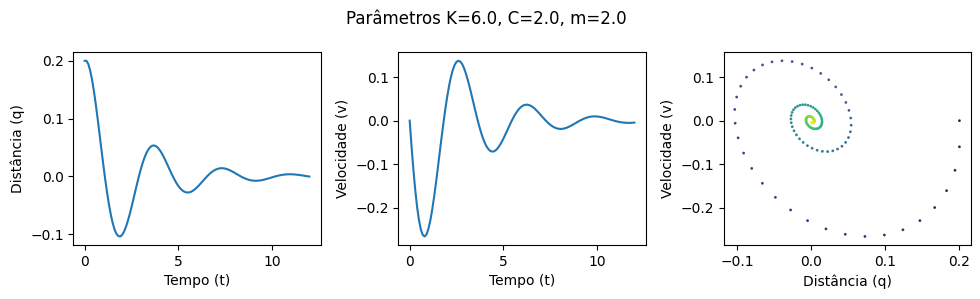

In [142]:
def show_trajectories(q_hist, v_hist, t):
    ' Mostra trajetórias de distância e velocidade versus tempo'
    _, ax = plt.subplots(1,3, figsize=(10,3))
    ax[0].plot(t,q_hist);
    ax[0].set_ylabel('Distância (q)');
    ax[0].set_xlabel('Tempo (t)');
    ax[1].plot(t,v_hist);
    ax[1].set_ylabel('Velocidade (v)');
    ax[1].set_xlabel('Tempo (t)');
    ax[2].scatter(q_hist,v_hist, s=1, alpha=0.9, c=t);
    ax[2].set_ylabel('Velocidade (v)');
    ax[2].set_xlabel('Distância (q)');
    plt.suptitle(f"Parâmetros K={K}, C={C}, m={m}")
    plt.tight_layout()

show_trajectories(q_hist, v_hist, t)

🤔  Pause um pouco e reflita sobre as curvas acima e o que elas significam em termos do comportamento do sistema físico mass-mola.
O último gráfico, em particular, contém o tempo implicitamente e determina como uma variável de estado se modificou em função da outra.

Depois, modifique o valor da constante elástica $K$ e simule novamente o comportamento do sistema, tentando relacionar os gráficos ao comportamento físico. Teste com $K=0.6$ e $K=60$. Quando terminar, retorne aos valores iniciais (rodando o código abaixo).

In [193]:
K = 6.0  # constante elástica
A = np.matrix([[0, 1], [-K/m, -C/m]])
print('A =\n', A)

A =
 [[ 0.  1.]
 [-3. -1.]]


## Estabilidade de sistemas dinâmicos

Há muitas formas de definir establidade de um sistema dinâmico. A mais comum é a que mede a estabilidade pela finitude da saída, chamado em inglês de [*Bounded-Input, Bounded-Output* (BIBO)](https://en.wikipedia.org/wiki/BIBO_stability). De acordo com esse conceito, um sistema descrito por estados $x_t$ é BIBO-estável se sua saída é limitada sempre que sua entrada também o for. Um sinal $s_t$ é limitado se existe uma constante $B > 0$ que limita superiormente a magnitude do sinal isto é, se $|s_t| < B$ para qualquer $t > 0$. Por exemplo, o sistema de tempo contínuo descrito pela equação 
$$
x_t = e^{-t} u_t
$$ 
é BIBO-estável, pois para $|u_t| < C$ temos que $|x_t| < C$ para qualquer $C > 0$. Note que o sistema não é limitado para $u_t = e^{2t}$, porém esse sinal de entrada também não é limitado (e portanto não viola a propriedade de BIBO-estabilidade do sistema). Agora considere o sistema descrito por
$$
x_t = 2t + u_t .
$$
Tal sistema não é BIBO-estável, pois nesse caso mesmo para $u_t=0$ temos para qualquer $C$ um $t$ suficientemente grande tal que $|x_t| > C$. 
Muitas vezes, a BIBO-estabilidade depende das condições iniciais de sistema. Nesse caso, é comum estabelecer BIBO-estabilidade assumindo condições iniciais nulas ($x_0 = 0$). Para sistemas forçados descritos por $\dot{x}_t = f_1(x_t,t) + f_2(u_t,t)$, também é comum estabelecer BIBO-estabilidade considerando um ponto estacionário $x_0=x^*$ da versão não-forçada do sistema $\dot{x}_t = f_1(x_t,t)$). Um *ponto estacionário* ou de equilíbrio $x^*$ para uma função $\dot{x} = f(x,t)$ é tal que $f(x^*,t) = 0$ para todo $t$. Em tal ponto, portanto, o sistema se torna estático e seu estado não se altera (na ausência de estímulos esternos ou de entrada).

## 💡 Exercício 1

Determine um ponto estacionário para o sistema massa-mola não-forçado $\dot{x}_t = A x_t$ com a matriz $A$ dada acima. Demonstre por meio da simulação que o sistema de fato se encontra em equilíbrio.

### RESPOSTA

<span style="color:red">Escreva sua resposta aqui</span>

In [ ]:
# Simulação do ponto estacionário:
# FAZER:

## 💡 Exercício 2

Considere o sistema massa-mola forçado descrito por $\dot{x}_t = Ax_t + B u_t$ com $x_0 = x^*$ sendo um ponto estacionário para o sistema não-forçado determinado no exercício anterior. Tal sistema é BIBO-estável? **Justifique sua resposta**, apontando porque o estado descrito pelo sistema será limitado com entradas limitadas ou apontando um contra-exemplo. Você pode usar as simulações das função `forward` como aproximações da dinâmica verdadeira do sistema para justificar sua resposta.

### RESPOSTA

<span style="color:red">Escreva sua resposta aqui</span>

In [ ]:
# Possível simulação

## Sistemas forçados e não forçados

A modelagem matemática de um sistema nos permite compreender a influência de certos parâmetros e entradas em seu comportamento, e também de encontrar uma função de entrada que leve o sistema a um comportamento adequado. Uma propriedade crucial, por exemplo, é estabelecer uma função de controle que torne um sistema instável em um sistema estável. Nessa finalidade, enxergamos um sistema com uma sinal de controle fixo como um novo sistema (não-forçado), o qual podemos analisar propriedades como estabilidade, ponto de equilíbrio etc.

Por exemplo, podemos querer investigar o sistema massa-mola descrito acima quando a entrada é a constante unitária $u_t = 1$. Para esse sistema temos o seguinte ponto estacionário
$$
A x^* + B = 0 \Rightarrow x^* = -A^{-1}B .
$$

In [147]:
# Ponto estacionário do sistema não-forçado correspondente
xstar = -(np.linalg.inv(A) @ B) 
print('x* =', xstar.T)

x* = [[ 0.16666667 -0.        ]]


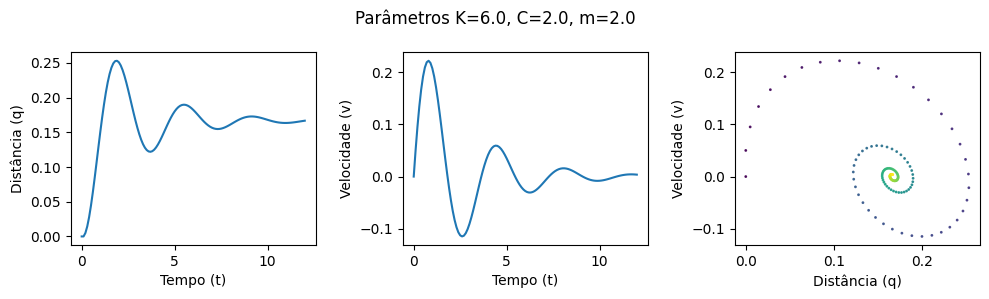

In [194]:
# Vamos simular a evolução do sistema não forçado acima a partir
# de um estado inicial estacionário com 120 passos de tempo dt = 0.1 [s]
dt = 0.1 # passo [s]
# vamos guardar o histórico dos estados
q_hist = []
v_hist = []
t = []

x = np.zeros((2,1))
q_hist.append(x[0,0])
v_hist.append(x[1,0])  

t.append(0.0)

for _ in range(120):
    forward(x, 1.0, dt)
    q_hist.append(x[0,0])
    v_hist.append(x[1,0])
    t.append(t[-1]+dt)  

show_trajectories(q_hist, v_hist, t)

Vamos considerar o seguinte sinal de controle:
$$
u_t = e^{-t} .
$$
Note que $u_t \rightarrow 0$ quando $t \rightarrow \infty$.

In [191]:
# Lei de controle com decaimento exponencial

def control(x, t):
    ' Lei de controle u(t,x)'
    return np.exp(-t)


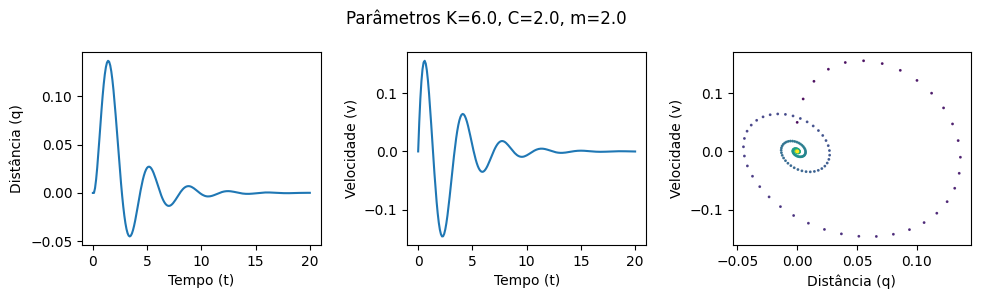

In [195]:
# Vamos simular a evolução do sistema não-forçado acima a partir
# de um estado inicial estacionário com 200 passos de tempo dt = 0.1 [s]
dt = 0.1 # passo [s]
# vamos guardar o histórico dos estados
q_hist = []
v_hist = []
t = []

x = np.zeros((2,1))
q_hist.append(x[0,0])
v_hist.append(x[1,0])  
t.append(0.0)

for _ in range(200):
    u = control(x, t[-1])
    forward(x, u, dt)
    q_hist.append(x[0,0])
    v_hist.append(x[1,0]) 
    t.append(t[-1]+dt)  

show_trajectories(q_hist, v_hist, t)

Vamos alterar a constante elástica do sistema para torná-lo instável (subamortecido).

In [202]:
# Definição dos parâmetros do sistema massa-mola subamortecido (instável)
# Constantes
K = 60.0  # constante elástica 
C = 2.0  # amortecimento
m = 2.0    # massa [kg]
# Estado x = [q, v]
# Matriz de transição homogênea
A = np.matrix([[0, 1], [-K/m, -C/m]])
print('A =\n', A)
# Componente não-homogêneo
B = np.matrix([[0],[1/m]])
print('B =\n', B)

A =
 [[  0.   1.]
 [-30.  -1.]]
B =
 [[0. ]
 [0.5]]


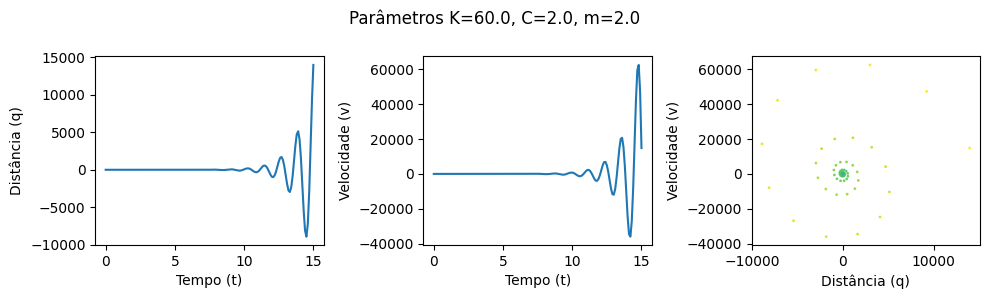

In [197]:
# Vamos simular a evolução do sistema não forçado acima a partir
# de um estado inicial estacionário com 150 passos de tempo dt = 0.1 [s]
dt = 0.1 # passo [s]
# vamos guardar o histórico dos estados
q_hist = []
v_hist = []
t = []

x = np.zeros((2,1))
q_hist.append(x[0,0])
v_hist.append(x[1,0])  
t.append(0.0)

for _ in range(150):
    u = control(x, t[-1])
    forward(x, u, dt)
    q_hist.append(x[0,0])
    v_hist.append(x[1,0]) 
    t.append(t[-1]+dt)  

show_trajectories(q_hist, v_hist, t)

Vamos agora considerar uma função de controle mais interessante:
$$
u_t = (\sin(3t) + \cos(4t))/(1+t) .
$$
Note que $u_t \rightarrow 0$ quando $t \rightarrow \infty$.

In [198]:
# Lei de controle sinosidal

def control(x, t):
    ' Lei de controle u(t,x)'
    return (np.sin(3*t) + np.cos(4*t))/(1+t)

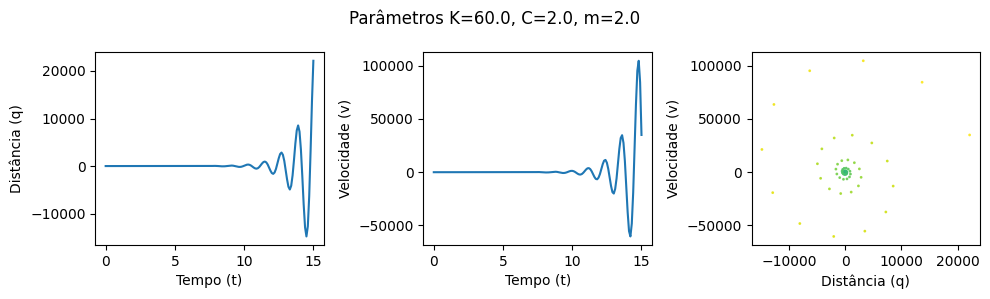

In [199]:
# Vamos simular a evolução do sistema não forçado acima a partir
# de um estado inicial estacionário com 150 passos de tempo dt = 0.1 [s]
dt = 0.1 # passo [s]
# vamos guardar o histórico dos estados
q_hist = []
v_hist = []
t = []

x = np.zeros((2,1))
q_hist.append(x[0,0])
v_hist.append(x[1,0])  
t.append(0.0)


for _ in range(150):
    u = control(x, t[-1])
    forward(x, u, dt)
    q_hist.append(x[0,0])
    v_hist.append(x[1,0]) 
    t.append(t[-1]+dt)  

show_trajectories(q_hist, v_hist, t)

## Estabilização e Retroalimentação

Um uso importante da modelagem de sistemas dinâmicos é o de projetar sinais de controle que estabilize um sistema instável. Para nosso sistema massa-mola, queremos encontrar $u_t$ que faça o sistema não-forçado equivalente convergir a um estado de equilíbrio. Vamos procurar por uma lei de controle **retroalimentada**
$$
u_t = K_u x_t .
$$
A regra acima é retroalimentada pois define a *entrada* em função do estado (saída) do sistema. Ela é linear pois define uma transformação linear do estado. 
Colocando tal equação nas EDO do sistemas, chegamos a equação de nosso sistema controlado não-forçado equivalente:
$$
\dot{x}_t = (A+BK_u)x_t + B.
$$
O ponto de equilíbrio de tal sistema é
$$
x^* = -(A+BK_u)^{-1}B .
$$
Queremos portanto encontrar a matriz $K_u$ de *ganho do controlador* que torne o sistema estável.

## 💡 Exercício

Encontre uma matriz $K_u = \begin{pmatrix} 0 & c \end{pmatrix}$ que faça o sistema convergir para um ponto de equilíbrio a partir da solução inicial $x_0 = \begin{pmatrix} 2 & 0 \end{pmatrix}$.

In [254]:
# Lei de controle retroalimentada
Ku = np.matrix([[0.0, 0.0]]) 
# Encontre o valor da segunda coordenada da matriz acima
# que faça o sistema convergir (deixe a primeira = 0)

print('Ku =', Ku)
print('x* = ', (np.linalg.inv(A+B @ Ku)*B).T)

def control(x, t):
    ' Lei de controle u(t,x)'
    return Ku @ x

Ku = [[0. 0.]]
x* =  [[-0.01666667  0.        ]]


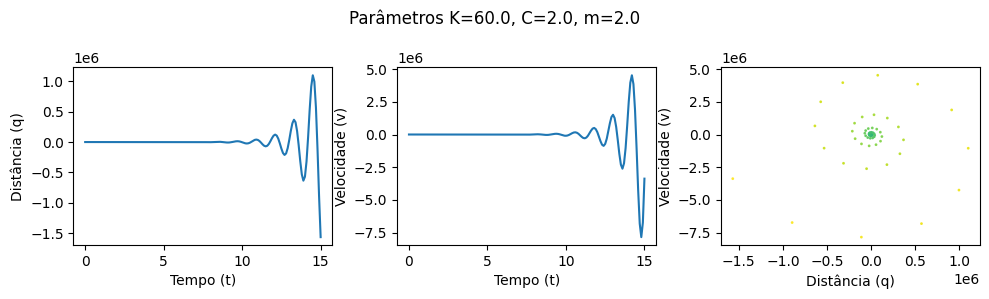

In [255]:
# Vamos simular a evolução do sistema não forçado acima a partir
# de um estado inicial estacionário com 150 passos de tempo dt = 0.1 [s]
dt = 0.1 # passo [s]
# vamos guardar o histórico dos estados
q_hist = []
v_hist = []
t = []

x = np.matrix([[2.0], [0.0]]) # vamos começar de um ponto de não equilíbrio (senão o problema de controle é trivial)
q_hist.append(x[0,0])
v_hist.append(x[1,0])  
t.append(0.0)


for _ in range(150):
    u = control(x, t[-1])
    forward(x, u, dt)
    q_hist.append(x[0,0])
    v_hist.append(x[1,0]) 
    t.append(t[-1]+dt)  

show_trajectories(q_hist, v_hist, t)